In [11]:
import cv2
import tkinter as tk
from tkinter import filedialog

# import datetime
# import os

from math import degrees, radians
from pprint import pprint

import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
# import pydicom

# from skimage.io import imread
# from skimage.draw import circle, line
from skimage.color import gray2rgb, rgb2gray

from scipy.fftpack import fft, ifft, fftfreq
import matplotlib.pyplot as plt


Obsługa ładowania zdjęcia

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 

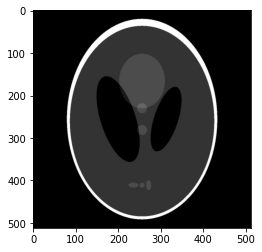

In [12]:
def choose_file():
    root = tk.Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    filename = filedialog.askopenfilename(initialdir="..", title="Wybierz obraz", filetypes=(("jpeg files", ".jpg"), ("all files", ".")))
    %gui tk
    # root.destroy()
    return filename

filename = choose_file()
img = cv2.imread(filename, 0)
img = cv2.resize(img,(512,512))
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
print(img)
R = img.shape[0]/2
print(R)
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

Emitery i detekotry

In [13]:
def circle_points(angle_shift, angle_range, count, radius=1, center=(0, 0)): # center (256:256) radius = 256 *sqrt2
    angles = np.linspace(0, angle_range, count) + angle_shift
    cx, cy = center
    x = radius * np.cos(angles) - cx
    y = radius * np.sin(angles) - cy
    points = np.array(list(zip(x, y)))
    return np.floor(points).astype(int)

def detector_coords(alpha, angle_range, count, radius=1, center=(0,0)):
    return circle_points(radians(alpha - angle_range/2), radians(angle_range), count, radius, center)

def emitter_coords(alpha, angle_range, count, radius=1, center=(0,0)):
    return circle_points(radians(alpha - angle_range/2 + 180), radians(angle_range), count, radius, center)[::-1]

In [19]:
print(detector_coords(30,90,3,256 * np.sqrt(2)))

[[349 -94]
 [313 181]
 [ 93 349]]


Bresenham

In [15]:
def bresenham(x0, y0, x1, y1):
    if abs(y1 - y0) > abs(x1 - x0):
        swapped = True
        x0, y0, x1, y1 = y0, x0, y1, x1
    else:
        swapped = False
    m = (y1 - y0) / (x1 - x0) if x1 - x0 != 0 else 1
    q = y0 - m * x0
    if x0 < x1:
        xs = np.arange(np.floor(x0), np.ceil(x1) + 1, +1, dtype=int)
    else:
        xs = np.arange(np.ceil(x0), np.floor(x1) - 1, -1, dtype=int)
    ys = np.round(m * xs + q).astype(int)
    if swapped:
        xs, ys = ys, xs
    return np.array([xs, ys])

def radon_lines(emitters, detectors):
    return [np.array(bresenham(x0, y0, x1, y1)) for (x0, y0), (x1, y1) in zip(emitters, detectors)]

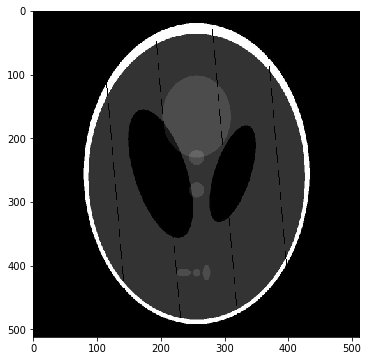

In [21]:
def center_of(array):
    """Center indices of an n-dimensional array"""
    return np.floor(np.array(array.shape) / 2).astype(int)

def draw_tomography(image):
    #image = circle_pad(image, constant_values=0.5)
    radius, center = image.shape[0]//2, center_of(image)
    fig, ax = plt.subplots(1, figsize=(6, 6))
    def do(alpha=0, detectors=50, angle_range=90):
        emitters = emitter_coords(alpha, angle_range, detectors, radius, center)
        detectors = detector_coords(alpha, angle_range, detectors, radius, center)
        lines = radon_lines(emitters, detectors)
        img = gray2rgb(image)
        for x, y in emitters:
            img[x-2:x+2,y-2:y+2] = (0,1,0)
        for x, y in detectors:
            img[x-2:x+2,y-2:y+2] = (1,0,0)
        for line in lines:
            img[tuple(line)] = (0,0,1)
        ax.imshow(img, aspect=1, interpolation='none')
    return do

#%matplotlib notebook
#widgets.interact(draw_tomography(image), alpha=(0,360,10), detectors=(0,100,5), angle_range=(45,270,5))
%matplotlib inline
draw_tomography(img)(alpha=5, angle_range=180, detectors=10)